# Entity Embeddding Using Fastai

## Installing Library

In [ ]:
!pip install -U fastai

     |████████████████████████████████| 189 kB 9.1 MB/s 
     |████████████████████████████████| 55 kB 5.0 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


## Class

In [ ]:
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import altair as alt
from sklearn.decomposition import PCA
from fastai.tabular.all import *

class EntEmbedding():

  def __init__(self, df, target):
    '''
    Parameters
    ----------
    df : dataframe 
       features and target you want to use
    target : str
       column name of your target 
    '''
    self.df = df
    self.target = target

  def cat_split(self, max_card=100):

      self.cont_names, self.cat_names = cont_cat_split(self.df, max_card = max_card, dep_var=self.target)
      self.procs_nn = [Categorify, FillMissing, Normalize]

      print(len(self.cont_names), "Continous Features:", self.cont_names, '\n', len(self.cat_names), "Categorical Features:", self.cat_names) 
    



  def find_alpha(self, regression=True, batch_size=1024, layer_size=[500, 250],  metrics = rmse):
      '''
      max_card : int
            if nunique > max_card value, it will be identified as continous, otherwis caregorical
      batch_size : int
            batch size used during training
      layer_size : list
            layer widths with to layers
      metrics : function
            uses sklearn metric names

      '''
      if regression:
         self.df.loc[:, self.target] = self.df.loc[:, self.target].astype(np.float32)
         to_nn = TabularPandas(self.df, self.procs_nn, self.cat_names, self.cont_names,
                             splits=RandomSplitter()(range_of(self.df)), y_names=self.target)
         self.dls = to_nn.dataloaders(batch_size)
         y = to_nn.train.y
         self.learn = tabular_learner(self.dls, layers=layer_size, y_range=(y.min(),y.max()), n_out=1, 
                                      metrics = metrics)
      else:

         to_nn = TabularPandas(self.df, self.procs_nn, self.cat_names, self.cont_names,
                             splits=RandomSplitter()(range_of(self.df)), y_names=self.target, y_block=CategoryBlock())
         self.dls = to_nn.dataloaders(batch_size)
        
         self.learn = tabular_learner(self.dls, layers=layer_size, 
                                      metrics = metrics)

      self.alpha =  self.learn.lr_find()
      print(self.alpha)

  def fit(self, epochs = 50, alpha = 1e-3):
     '''
     epochs : int
        number of epochs model will be trained during fit
     alpha : int
        learning rate. preferrably you should set this parameter to the value returned by .find_alpha() method
     '''
     self.learn.fit_one_cycle(n_epoch=epochs, lr_max=alpha)
  
  def embed_features(self, learner, xs, variable):
    #parameters for embed_features(model.learn, model.dls.train.xs, 'column_you_want_visualization_for')  
    xs = xs.copy()
    self.var = variable
    new = []
    for i, feature in enumerate(learner.dls.cat_names):
        emb = learner.model.embeds[i]
        new_feat = pd.DataFrame(emb(tensor(xs[feature], dtype=torch.int64)), index=xs.index, columns=[f'{feature}_{j}' for j in range(emb.embedding_dim)])
        new.append(new_feat)
        ix = learner.dls.cat_names.index(variable)
        self.var_vals = list(self.df[variable].astype('category').cat.categories.values)
        emb_mx = to_np(next(learner.model.embeds[ix].parameters()))
        self.X_emb = PCA(n_components=2).fit_transform(emb_mx)
    new = pd.concat(new, axis=1)
        
    return new


  def visualize(self):
          emb_df = pd.DataFrame(self.X_emb[1:], columns=['Dim1', 'Dim2'])
          emb_df[self.var]=np.array(self.var_vals)
          points = alt.Chart(emb_df).mark_circle(size=60).encode(
              x='Dim1',
              y='Dim2',
              tooltip=[self.var]
          )

          text = points.mark_text(
              align='left',
              baseline='middle',
              dx=7
          ).encode(
              text=self.var
          )

          graph=points + text
                     

          return graph

## Classification

In [ ]:
df = pd.read_csv('Credit Card Defaulter Prediction.csv')

In [ ]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,F,University,Married,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,Y
1,2,120000,F,University,Single,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,Y
2,3,90000,F,University,Single,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,N
3,4,50000,F,University,Married,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,N
4,5,50000,M,University,Married,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,N


In [ ]:
df.columns.nunique()

25

In [ ]:
model = EntEmbedding(df, 'default ')

In [ ]:
model.cat_split()

13 Continous Features: ['ID', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'] 
 11 Categorical Features: ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']


SuggestedLRs(valley=0.0002754228771664202)


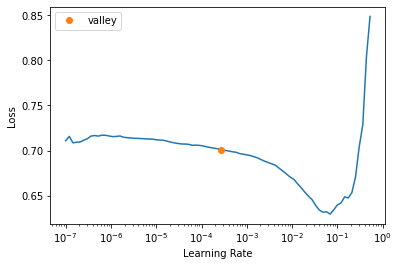

In [ ]:
model.find_alpha(regression=False, batch_size=512, metrics=[accuracy, error_rate, Recall(), Precision()])

In [ ]:
model.fit(10, 0.0002754228771664202)

epoch,train_loss,valid_loss,accuracy,error_rate,recall_score,precision_score,time
0,0.681153,0.684711,0.489167,0.510833,0.772973,0.265376,00:02
1,0.651224,0.588578,0.718500,0.281500,0.564479,0.393858,00:01
2,0.602620,0.519139,0.806500,0.193500,0.506564,0.556876,00:01
3,0.555510,0.496518,0.817833,0.182167,0.478764,0.597303,00:01
4,0.517279,0.485763,0.816500,0.183500,0.437838,0.603191,00:01
5,0.488450,0.464228,0.822667,0.177333,0.409266,0.639324,00:01
6,0.467969,0.448508,0.825000,0.175000,0.393050,0.658473,00:01
7,0.453973,0.443612,0.824333,0.175667,0.389189,0.657106,00:01
8,0.444545,0.443200,0.825500,0.174500,0.382239,0.667116,00:01
9,0.439678,0.440730,0.825833,0.174167,0.384556,0.667560,00:01


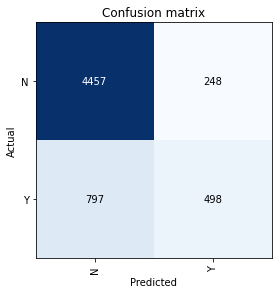

In [ ]:
interpret = ClassificationInterpretation.from_learner(model.learn)
interpret.plot_confusion_matrix()

In [ ]:
model.embed_features(model.learn, model.dls.train.xs, 'SEX')

,LIMIT_BAL_0,LIMIT_BAL_1,LIMIT_BAL_2,LIMIT_BAL_3,LIMIT_BAL_4,LIMIT_BAL_5,LIMIT_BAL_6,LIMIT_BAL_7,LIMIT_BAL_8,LIMIT_BAL_9,...,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_6_0,PAY_6_1,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5
21244,-0.004817,0.016504,0.017627,-0.017970,0.004937,0.017606,0.013842,-0.005106,-0.005615,-0.017256,...,-0.003209,0.001128,0.013949,0.005377,0.021175,-0.016521,0.014034,-0.013654,0.003649,0.016062
19206,0.012464,-0.008335,-0.006871,0.002461,-0.010686,-0.010642,-0.018236,-0.007424,0.007016,0.020526,...,-0.021335,-0.006303,0.024723,-0.011545,-0.010434,0.012170,-0.024108,0.029182,-0.012181,-0.015539
22231,-0.010098,0.015086,0.007548,0.007531,-0.013228,0.015454,-0.002603,0.015983,0.006568,0.003374,...,0.022148,0.014818,-0.028985,0.011752,0.021175,-0.016521,0.014034,-0.013654,0.003649,0.016062
14818,-0.003570,0.025207,-0.002092,-0.010014,0.008105,-0.006439,0.010896,0.025190,-0.008878,0.014528,...,-0.003209,0.001128,0.013949,0.005377,-0.001163,0.006328,0.012606,-0.017174,0.013138,0.018224
2135,-0.004817,0.016504,0.017627,-0.017970,0.004937,0.017606,0.013842,-0.005106,-0.005615,-0.017256,...,0.022148,0.014818,-0.028985,0.011752,0.021175,-0.016521,0.014034,-0.013654,0.003649,0.016062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16264,0.007265,-0.025644,-0.021211,0.012108,0.004013,-0.004308,-0.009573,-0.007943,-0.012500,-0.012540,...,0.022148,0.014818,-0.028985,0.011752,0.021175,-0.016521,0.014034,-0.013654,0.003649,0.016062
9343,-0.014240,0.009283,0.004489,-0.001178,0.013057,-0.001711,0.007453,-0.002063,-0.006955,-0.006178,...,-0.021335,-0.006303,0.024723,-0.011545,0.021175,-0.016521,0.014034,-0.013654,0.003649,0.016062
18770,-0.004923,-0.014553,-0.008775,0.002554,-0.001288,-0.001995,-0.004906,0.001279,-0.006379,-0.012055,...,0.022148,0.014818,-0.028985,0.011752,0.021175,-0.016521,0.014034,-0.013654,0.003649,0.016062
1857,0.005958,0.003494,0.012471,-0.021641,0.005740,-0.002798,0.008326,0.017924,0.000213,0.003072,...,0.022148,0.014818,-0.028985,0.011752,0.021175,-0.016521,0.014034,-0.013654,0.003649,0.016062


In [ ]:
model.visualize()

alt.LayerChart(...)

## Regression

In [ ]:
df_reg = pd.read_csv('https://raw.githubusercontent.com/wblakecannon/ames/master/data/housing.csv')

In [ ]:
df_reg.head()

,Unnamed: 0,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [ ]:
model = EntEmbedding(df_reg, 'SalePrice')

In [ ]:
df_reg = df_reg[['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Sale Condition', 'Neighborhood', 'SalePrice']]

In [ ]:
df_reg.nunique()

MS SubClass         16
MS Zoning            7
Lot Frontage       128
Lot Area          1960
Street               2
Sale Condition       6
Neighborhood        28
SalePrice         1032
dtype: int64

In [ ]:
model.cat_split()

23 Continous Features: ['Unnamed: 0', 'Order', 'PID', 'Lot Frontage', 'Lot Area', 'Year Built', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', 'Screen Porch'] 
 59 Categorical Features: ['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air', 'Electrical', 'Low Qual Fin SF', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 

SuggestedLRs(valley=0.0005754399462603033)


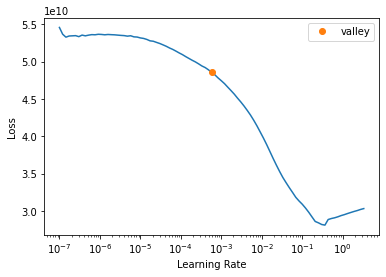

In [ ]:
model.find_alpha(regression=True)

In [ ]:
model.fit(20,0.0005754399462603033)

epoch,train_loss,valid_loss,_rmse,time
0,53399339008.000000,48491773952.000000,220208.484375,00:00
1,52050575360.000000,46840012800.000000,216425.531250,00:00
2,50026217472.000000,44949491712.000000,212012.953125,00:00
3,48428531712.000000,42850828288.000000,207004.421875,00:00
4,46998200320.000000,40385642496.000000,200961.796875,00:00
5,45283008512.000000,37678538752.000000,194109.609375,00:00
6,43752398848.000000,35121188864.000000,187406.484375,00:00
7,42188840960.000000,33058336768.000000,181819.515625,00:00
8,40745279488.000000,31725031424.000000,178115.218750,00:00
9,39510605824.000000,31175006208.000000,176564.453125,00:00


In [ ]:
model.embed_features(model.learn, model.dls.train.xs, 'Neighborhood')

,MS SubClass_0,MS SubClass_1,MS SubClass_2,MS SubClass_3,MS SubClass_4,MS SubClass_5,MS SubClass_6,MS SubClass_7,MS Zoning_0,MS Zoning_1,...,Bsmt Half Bath_na_2,Garage Yr Blt_na_0,Garage Yr Blt_na_1,Garage Yr Blt_na_2,Garage Cars_na_0,Garage Cars_na_1,Garage Cars_na_2,Garage Area_na_0,Garage Area_na_1,Garage Area_na_2
1051,0.009091,0.008579,-0.006989,0.004335,-0.019157,-0.003362,-0.002041,0.005086,0.017172,-0.012495,...,-0.010311,-0.005205,0.009649,0.009373,0.00623,-0.011999,-0.017049,0.021268,-0.016261,0.013667
733,-0.016629,0.005069,0.012303,-0.008578,-0.000559,-0.011044,-0.012796,-0.002911,0.003793,0.000120,...,-0.010311,-0.005205,0.009649,0.009373,0.00623,-0.011999,-0.017049,0.021268,-0.016261,0.013667
2013,-0.016629,0.005069,0.012303,-0.008578,-0.000559,-0.011044,-0.012796,-0.002911,0.003793,0.000120,...,-0.010311,-0.005205,0.009649,0.009373,0.00623,-0.011999,-0.017049,0.021268,-0.016261,0.013667
2280,-0.004189,-0.012917,-0.004689,0.002519,0.011867,0.016905,0.010677,-0.011145,0.017172,-0.012495,...,-0.010311,-0.005205,0.009649,0.009373,0.00623,-0.011999,-0.017049,0.021268,-0.016261,0.013667
1573,-0.004189,-0.012917,-0.004689,0.002519,0.011867,0.016905,0.010677,-0.011145,0.017172,-0.012495,...,-0.010311,-0.005205,0.009649,0.009373,0.00623,-0.011999,-0.017049,0.021268,-0.016261,0.013667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2289,0.006258,0.007133,0.003289,-0.003484,-0.000378,0.002977,-0.005251,0.005759,0.003793,0.000120,...,-0.010311,0.008258,0.000009,-0.013701,0.00623,-0.011999,-0.017049,0.021268,-0.016261,0.013667
1394,-0.008712,-0.020439,-0.003791,0.003285,-0.014913,0.011736,0.003387,0.000479,0.017172,-0.012495,...,-0.010311,-0.005205,0.009649,0.009373,0.00623,-0.011999,-0.017049,0.021268,-0.016261,0.013667
1432,-0.004189,-0.012917,-0.004689,0.002519,0.011867,0.016905,0.010677,-0.011145,0.017172,-0.012495,...,-0.010311,-0.005205,0.009649,0.009373,0.00623,-0.011999,-0.017049,0.021268,-0.016261,0.013667
2318,0.009091,0.008579,-0.006989,0.004335,-0.019157,-0.003362,-0.002041,0.005086,0.017172,-0.012495,...,-0.010311,-0.005205,0.009649,0.009373,0.00623,-0.011999,-0.017049,0.021268,-0.016261,0.013667


In [ ]:
model.visualize()

alt.LayerChart(...)